In [1]:
from pathlib import Path
import os

os.chdir(Path.cwd().parent)
assert (Path.cwd() / "pyproject.toml").exists()

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

from pmrisk.eval.thresholds import select_threshold
from pmrisk.features.contracts import validate_tabular_features
from pmrisk.features.tabular import build_tabular_features
from pmrisk.models.model_builder import build_sequence_model
from pmrisk.models.sequence_data import build_sequence_pipeline
from pmrisk.models.torch_dataset import SequenceWindowDataset
from pmrisk.models.train_sequence import (
    filter_index_by_engine_ids,
    predict_logits,
    select_threshold_for_policy,
    train_sequence_model,
)
from pmrisk.split.splitter import split_engine_ids

In [3]:
def load_config(path):
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

base_cfg = load_config("configs/base.yaml")
feat_cfg = load_config("configs/features.yaml")
split_cfg = load_config("configs/split.yaml")
thresh_cfg = load_config("configs/thresholds.yaml")

window_l = base_cfg["window_l"]
random_seed = base_cfg["random_seed"]

np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [4]:
processed_dir = Path(base_cfg["data_processed_dir"])
df_full = pd.read_parquet(processed_dir / "fd001_train.parquet")
df_labels = pd.read_parquet(processed_dir / "fd001_train_labeled.parquet")

all_engine_ids = sorted(df_full["engine_id"].unique().tolist())
splits = split_engine_ids(
    all_engine_ids,
    split_cfg["train_ratio"],
    split_cfg["val_ratio"],
    split_cfg["test_ratio"],
    split_cfg["seed"],
)

feat_spec = {
    "windows": feat_cfg["windows"],
    "stats": feat_cfg["stats"],
    "lags": feat_cfg["lags"],
    "deltas": feat_cfg["deltas"],
    "include_slopes": feat_cfg["include_slopes"],
}

df_feat = build_tabular_features(df_full, feat_spec, window_l, filter_after=True)
validate_tabular_features(df_feat, window_l)

label_cols = ["engine_id", "cycle", "label"]
if "remaining" in df_labels.columns:
    label_cols.append("remaining")

df_feat = df_feat.merge(df_labels[label_cols], on=["engine_id", "cycle"], how="inner")

exclude = {"engine_id", "cycle", "label", "remaining", "failure_cycle"}
feature_columns = sorted([c for c in df_feat.columns if c not in exclude])

train_df = df_feat[df_feat["engine_id"].isin(splits["train"])]
val_df = df_feat[df_feat["engine_id"].isin(splits["val"])]
test_df = df_feat[df_feat["engine_id"].isin(splits["test"])]

X_train, y_train = train_df[feature_columns], train_df["label"]
X_val, y_val = val_df[feature_columns], val_df["label"]
X_test, y_test = test_df[feature_columns], test_df["label"]

print(f"Features: {len(feature_columns)}")
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Features: 216
Train: 11204, Val: 2325, Test: 2202


In [5]:
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced", max_iter=1000, random_state=random_seed,
    )),
])
logreg.fit(X_train, y_train)

lgbm = lgb.LGBMClassifier(
    random_state=random_seed,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    class_weight="balanced",
    verbosity=-1,
)
lgbm.fit(X_train, y_train)

models_probas = {
    "Logistic Regression": {
        "val": logreg.predict_proba(X_val)[:, 1],
        "test": logreg.predict_proba(X_test)[:, 1],
    },
    "LightGBM": {
        "val": lgbm.predict_proba(X_val)[:, 1],
        "test": lgbm.predict_proba(X_test)[:, 1],
    },
}

y_splits = {
    "val": y_val.to_numpy(),
    "test": y_test.to_numpy(),
}

In [6]:
def train_sequence(model_type):
    pipeline = build_sequence_pipeline(
        df_labels,
        train_engine_ids=splits["train"],
        window_length=window_l,
        label_col="label",
    )

    engine_arrays = pipeline["engine_arrays"]
    index = pipeline["index"]

    loaders = {}
    for split_name in ("train", "val", "test"):
        idx = filter_index_by_engine_ids(index, set(splits[split_name]))
        ds = SequenceWindowDataset(engine_arrays, idx, window_l)
        loaders[split_name] = DataLoader(ds, batch_size=32, shuffle=False)

    hparams = {
        "model_type": model_type,
        "n_features": len(pipeline["feature_columns"]),
        "window_l": window_l,
    }
    if model_type == "cnn":
        hparams.update({"hidden_channels": 8, "kernel_size": 3, "dropout_p": 0.0})
    else:
        hparams.update({"hidden_size": 32, "num_layers": 1, "dropout_p": 0.0})

    model = build_sequence_model(hparams)
    device = torch.device("cpu")
    model.to(device)

    result = train_sequence_model(
        model, loaders["train"], loaders["val"], device,
        n_epochs=20, patience=5, lr=1e-3,
    )

    model.load_state_dict(result["best_state_dict"])
    model.eval()

    probas = {}
    labels = {}
    for split_name in ("val", "test"):
        logits, y_true = predict_logits(model, loaders[split_name], device)
        labels[split_name] = y_true.view(-1).numpy()
        probas[split_name] = torch.sigmoid(logits.view(-1)).numpy()

    return probas, labels

for model_type, display in [("cnn", "1D-CNN"), ("gru", "GRU")]:
    print(f"Training {model_type}")
    probas, seq_labels = train_sequence(model_type)
    models_probas[display] = probas

Training cnn
Training gru


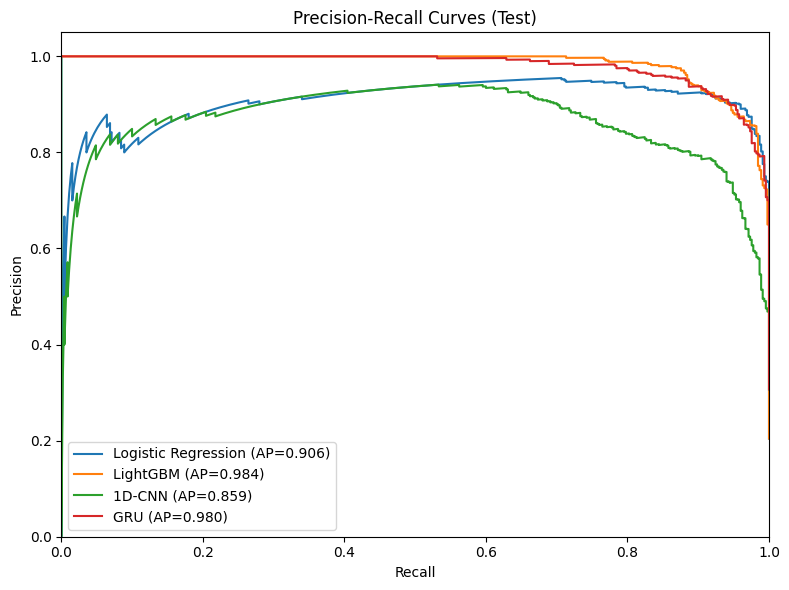

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

for name, probas in models_probas.items():
    y = y_splits["test"] if name in ("Logistic Regression", "LightGBM") else seq_labels["test"]
    p = probas["test"]
    prec, rec, _ = precision_recall_curve(y, p)
    ap = average_precision_score(y, p)
    ax.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curves (Test)")
ax.legend(loc="lower left")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
plt.tight_layout()
plt.show()

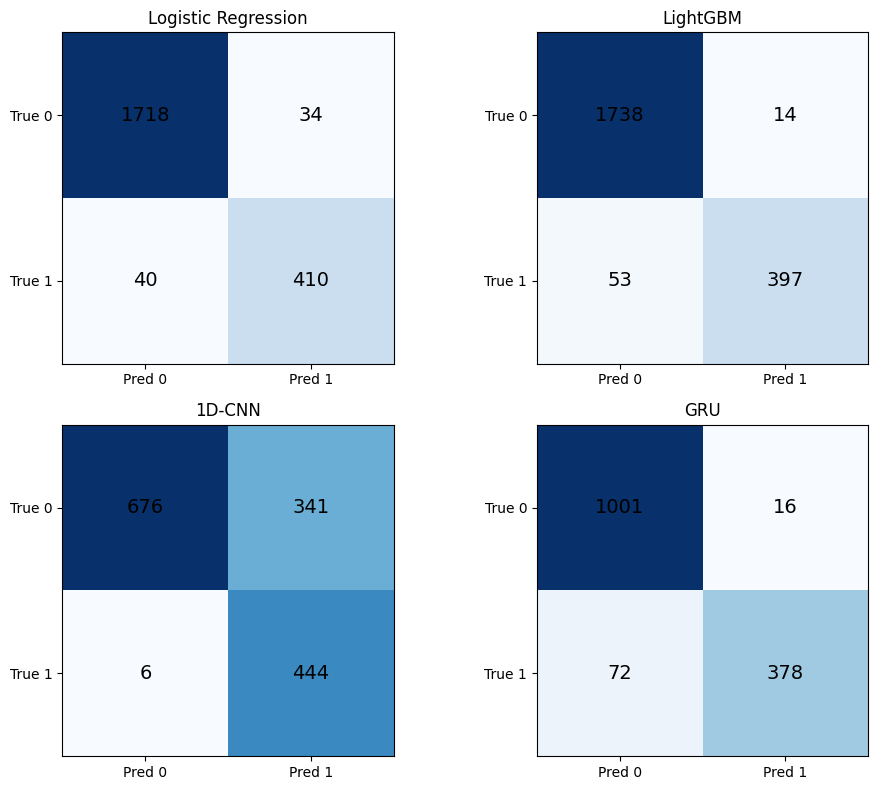

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
model_names = ["Logistic Regression", "LightGBM", "1D-CNN", "GRU"]

for ax, name in zip(axes.flat, model_names):
    y = y_splits["test"] if name in ("Logistic Regression", "LightGBM") else seq_labels["test"]
    p = models_probas[name]["test"]

    proba_val = models_probas[name]["val"]
    y_val_local = y_splits["val"] if name in ("Logistic Regression", "LightGBM") else seq_labels["val"]

    if name in ("1D-CNN", "GRU"):
        threshold = select_threshold_for_policy(
            torch.tensor(y_val_local), torch.tensor(proba_val),
            target_recall=thresh_cfg["target_recall"],
            min_precision=thresh_cfg["min_precision"],
        )
    else:
        threshold = select_threshold(
            y_val_local, proba_val,
            thresh_cfg["target_recall"],
            thresh_cfg["min_precision"],
        )

    y_pred = (p >= threshold).astype(int)
    cm = confusion_matrix(y, y_pred, labels=[0, 1])

    im = ax.imshow(cm, cmap="Blues")
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=14)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])
    ax.set_title(name)

plt.tight_layout()
plt.show()

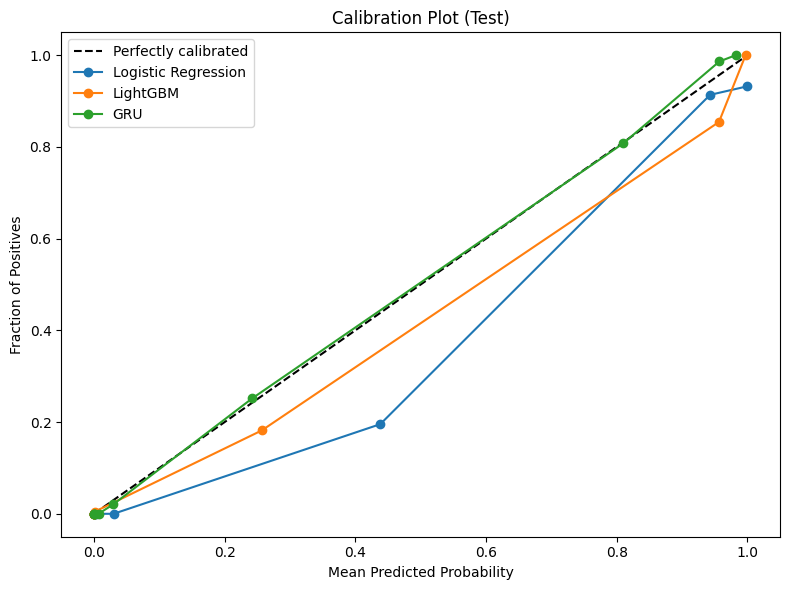

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

for name in ("Logistic Regression", "LightGBM", "GRU"):
    y = y_splits["test"] if name in ("Logistic Regression", "LightGBM") else seq_labels["test"]
    p = models_probas[name]["test"]
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=10, strategy="quantile")
    ax.plot(mean_pred, frac_pos, "o-", label=name)

ax.set_xlabel("Mean Predicted Probability")
ax.set_ylabel("Fraction of Positives")
ax.set_title("Calibration Plot (Test)")
ax.legend()
plt.tight_layout()
plt.show()

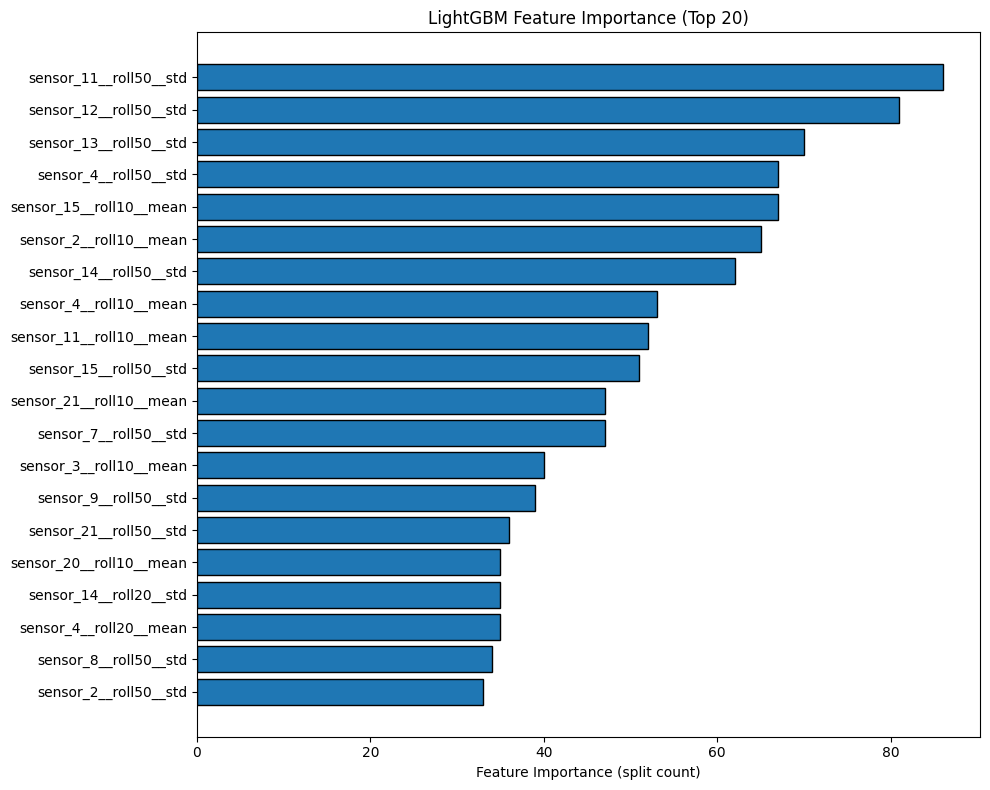

In [10]:
importances = lgbm.feature_importances_
indices = np.argsort(importances)[-20:]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(len(indices)), importances[indices], edgecolor="black")
ax.set_yticks(range(len(indices)))
ax.set_yticklabels([feature_columns[i] for i in indices])
ax.set_xlabel("Feature Importance (split count)")
ax.set_title("LightGBM Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

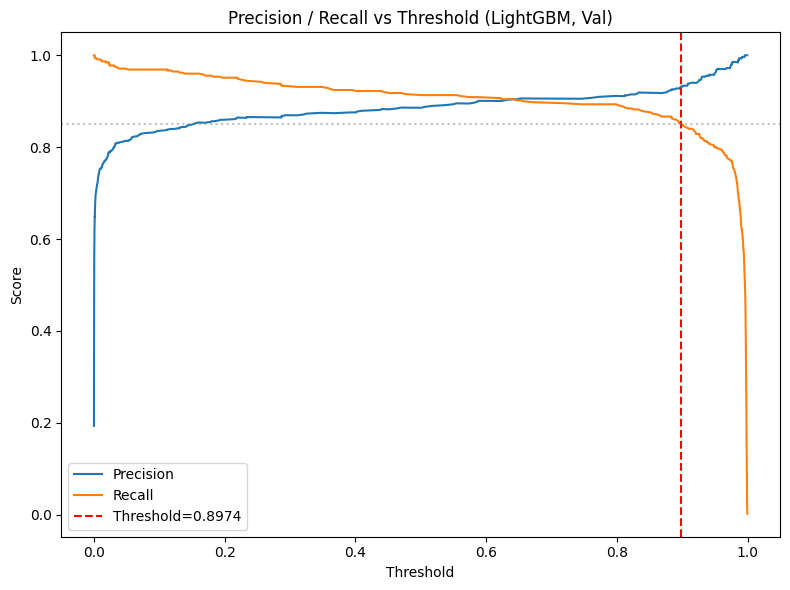

In [11]:
proba_val_lgbm = models_probas["LightGBM"]["val"]
prec_curve, rec_curve, thresholds = precision_recall_curve(y_splits["val"], proba_val_lgbm)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, prec_curve[:-1], label="Precision")
ax.plot(thresholds, rec_curve[:-1], label="Recall")

chosen_threshold = select_threshold(
    y_splits["val"], proba_val_lgbm,
    thresh_cfg["target_recall"],
    thresh_cfg["min_precision"],
)
ax.axvline(chosen_threshold, color="red", linestyle="--", label=f"Threshold={chosen_threshold:.4f}")
ax.axhline(thresh_cfg["target_recall"], color="gray", linestyle=":", alpha=0.5)

ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Precision / Recall vs Threshold (LightGBM, Val)")
ax.legend()
plt.tight_layout()
plt.show()